In [3]:
%matplotlib inline
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
m = 5000
n = 400
alpha = 0.0011
mat = scipy.io.loadmat('ex3data1.mat')
x = mat['X']
y = mat['y']

(-0.5, 19.5, 19.5, -0.5)

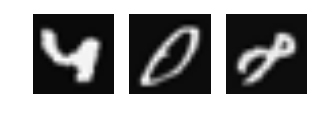

In [2]:
# print a sample digit
plt.figure(1)
plt.subplot(251)
plt.axis('off')
plt.imshow(x[1200].reshape((20, 20)), cmap='gray')
plt.subplot(252)
plt.axis('off')
plt.imshow(x[101].reshape((20, 20)), cmap='gray')
plt.subplot(253)
plt.imshow(x[4302].reshape((20, 20)), cmap='gray')
plt.axis('off')

# Simple regularized regression 

This is doing the all-vs-one classification with a for loop

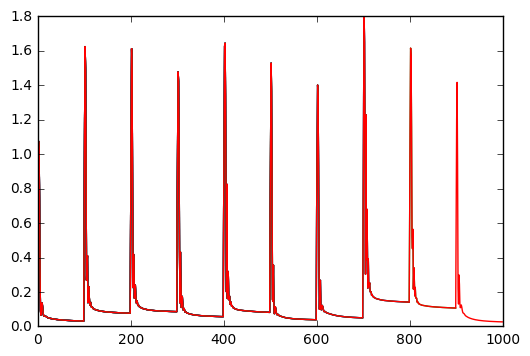

In [3]:
def sigmoid(el):
    return 1. / (1 + tf.exp(-el))
def unregularized_regression():
    costs = []
    l = 0.0
    alpha = 1.7
    mat_t = []
    for k in range(1, 11):
        X = tf.placeholder(tf.float64)
        Y = tf.placeholder(tf.float64)
        T = tf.Variable(tf.zeros([1, n], dtype=tf.float64))
        h = sigmoid(tf.matmul(X, tf.transpose(T)))

        J = tf.reduce_sum(-Y * tf.log(h) - (1 - Y) * tf.log(1 - h)) / m + l * tf.reduce_sum(tf.slice(T ** 2, [0, 1], [1, -1])) / 2 / m

        train = tf.train.MomentumOptimizer(alpha, 0.7).minimize(J)

        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)

        for i in range(100):
            _, b = sess.run([train, J], { X: x, Y: np.where(y == k, 1, 0) })
            costs.append(b)

        plt.plot(costs)
        mat_t.append(sess.run(T)[0])
    return mat_t
a = unregularized_regression()

In [4]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
predictions = tf.reshape(tf.argmax(sigmoid(tf.matmul(x, np.array(a).T)), 1) + 1, (m, 1))

In [5]:
sess.run(tf.reduce_mean(tf.cast(tf.equal(predictions, y), tf.float32)))

0.92140001

# Regression in one pass

In [6]:
sess.run(tf.one_hot(y, 11, 1, 0))[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

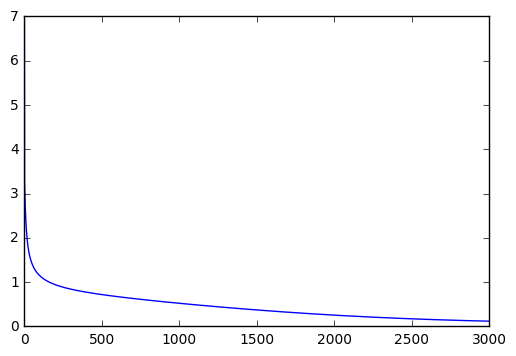

In [7]:
alpha = 0.3
l = 0
costs = []
accuracies = []
X = tf.Variable(x, dtype=tf.float32)
raw_Y = tf.Variable(y, dtype=tf.int32)
Y = tf.slice(tf.reshape(tf.one_hot(raw_Y, 11, 1., 0.), [m, 11]), [0, 1], [-1, 10])
T = tf.Variable(tf.zeros([10, n], dtype=tf.float32))
b = tf.Variable(tf.zeros(10.))
h = sigmoid(tf.matmul(X, tf.transpose(T)) + b)
J = tf.reduce_sum(-Y * tf.log(h) - (1 - Y) * tf.log(1 - h)) / m + l * tf.reduce_sum(T ** 2) + l * tf.reduce_sum(b ** 2)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.reshape(tf.argmax(h, 1) + 1, [m, 1]), y), tf.float32))
train = tf.train.GradientDescentOptimizer(alpha).minimize(J)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for i in range(3000):
    _, c, d = sess.run([train, J, accuracy])
    costs.append(c)
    accuracies.append(d)
plt.plot(costs)

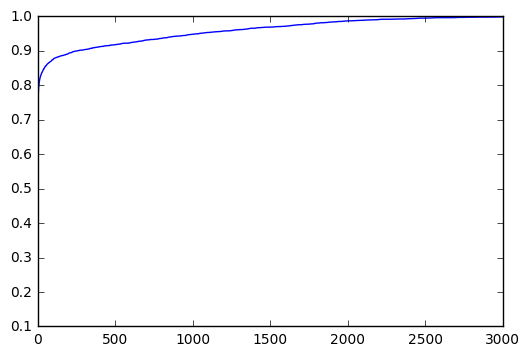

In [8]:
plt.plot(accuracies)

In [9]:
sess.run(accuracy)

0.99860001

I guess I won. /s

# The whole thing

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


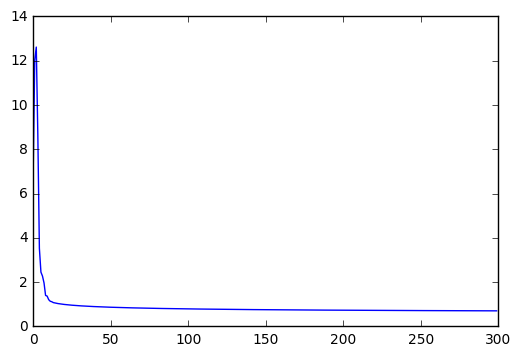

In [2]:
def sigmoid(el):
    return 1. / (1 + tf.exp(-el))

alpha = 0.9
l = 0
n = 784
m = 55000
costs = []
accuracies = []
X = tf.placeholder(tf.float64)
Y = tf.placeholder(tf.float64)

T = tf.Variable(tf.zeros([10, n], dtype=tf.float64))
b = tf.Variable(tf.zeros(10., dtype=tf.float64))
h = sigmoid(tf.matmul(X, tf.transpose(T)) + b)
J = tf.reduce_sum(-Y * tf.log(h) - (1 - Y) * tf.log(1 - h)) / m + l * tf.reduce_sum(T ** 2) + l * tf.reduce_sum(b ** 2)

correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(h,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
train = tf.train.MomentumOptimizer(alpha, 0.4).minimize(J)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for i in range(300):
    _, c, d = sess.run([train, J, accuracy], { X: mnist.train.images, Y: mnist.train.labels})
    costs.append(c)
    accuracies.append(d)

plt.plot(costs)

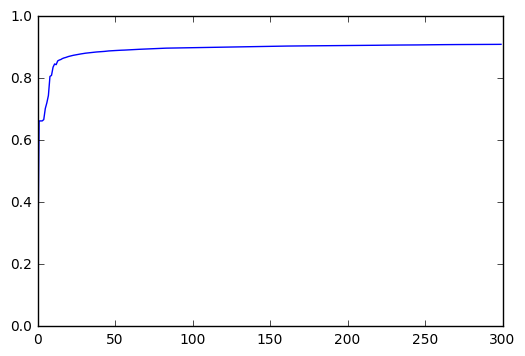

In [3]:
plt.plot(accuracies)

In [4]:
# Evaluate on test
X_test = tf.placeholder(tf.float64)
Y_test = tf.placeholder(tf.float64)
hypo = sigmoid(tf.matmul(X_test, tf.transpose(T)) + b)
correct_prediction = tf.equal(tf.argmax(Y_test,1), tf.argmax(hypo,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(accuracy, { X_test: mnist.test.images, Y_test: mnist.test.labels})

0.91460001

In [28]:
# Use TF Learn
import tensorflow.contrib.learn.python.learn as learn
import numpy as np
from sklearn import metrics

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=n)]
#classifier = learn.LinearClassifier(n_classes=10, feature_columns=feature_columns)
classifier = learn.DNNClassifier(hidden_units=[100, 200, 10], n_classes=10, feature_columns=feature_columns)

classifier.fit(mnist.train.images, mnist.train.labels.astype(np.int32).argmax(axis=1), steps=2400)
predictions = list(classifier.predict(mnist.train.images, as_iterable=True))
score = metrics.accuracy_score(mnist.train.labels.astype(np.int32).argmax(axis=1), predictions)


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


In [29]:
score

0.99018181818181816

In [ ]:
mnist.train.labels.astype(np.int32).argmax(axis=1)